# Lab Deep Learning/ Recurrent Neural Networks/ in pytorch

## Training language model for generating sequences (One-to-Many)

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2024/06/11 (changed to pytorch, changed almost everything)

For any remark or suggestion, please feel free to contact me.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime) or a real performer (a musician reading a score).

- We will first train a language model on the whole set of MIDI files of the "Cello suites".
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [3]:
%pip install pretty_midi

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pretty_midi
from scipy.io import wavfile
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import glob
from argparse import Namespace
import time

student = True

## Parameters of the model

In [3]:
param = Namespace()

param.n_x = 79 # --- input dimension of x<t>, number of musical-pitch considered
param.max_midi_T_x = 1000 # --- maximum considered length of each bach suite
param.model_T_x = 100 # --- considered duration T_x of sequence for training and generation
param.model_n_a = 32 # --- hidden dimension of LSTM

param.dropout_rate = 0.3
param.batch_size = 64
param.n_epoch = 1000

param.model_T_generate = 100 # --- number of time steps to generate

# Get the data

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [4]:
import urllib.request
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1FzNBMlhSYdefQUHpfRykY05CsYkuI2Ez', 'Archive.zip');
import shutil
shutil.unpack_archive('Archive.zip', './', 'zip')

DIR = './'
midi_file_l = glob.glob(DIR + 'cs*.mid')
print(midi_file_l)

['./cs3-2all.mid', './cs5-5gav.mid', './cs2-4sar.mid', './cs2-5men.mid', './cs6-3cou.mid', './cs2-6gig.mid', './cs4-2all.mid', './cs1-3cou.mid', './cs5-6gig.mid', './cs5-4sar.mid', './cs3-4sar.mid', './cs3-6gig.mid', './cs1-1pre.mid', './cs2-2all.mid', './cs4-6gig.mid', './cs6-1pre.mid', './cs4-4sar.mid', './cs5-2all.mid', './cs6-2all.mid', './cs5-1pre.mid', './cs3-3cou.mid', './cs1-2all.mid', './cs4-3cou.mid', './cs2-1pre.mid', './cs2-3cou.mid', './cs4-1pre.mid', './cs6-6gig.mid', './cs6-4sar.mid', './cs3-5bou.mid', './cs1-5men.mid', './cs6-5gav.mid', './cs1-4sar.mid', './cs3-1pre.mid', './cs5-3cou.mid', './cs1-6gig.mid', './cs4-5bou.mid']


In [8]:
#DIR = './'
#import urllib.request
#midi_file_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
#for midi_file in midi_file_l:
#    #if os.path.isfile(DIR + midi_file) is None:
#    urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midi_file, DIR + midi_file)

#midi_file_l = glob.glob(DIR + 'cs*.mid')
#print(midi_file_l)

## Read and convert all MIDI files

We illustrate here the content of a MIDI file. Each file contains a list of notes to be played over time. Each note is characterized by
- its `pitch` (in MIDI note number, la3=A4=69)
- its `start` time (when to start playing the note)
- its `stop` time (when to stop playing the note)
- its `duration` (which is computed as stop-start)

In [5]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midi_file_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes[:10]:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 55, start: 1.020000, end: 1.320000, duration: 0.300000
pitch: 57, start: 1.320000, end: 1.620000, duration: 0.300000
pitch: 59, start: 1.620000, end: 1.920000, duration: 0.300000
pitch: 60, start: 1.920000, end: 2.220000, duration: 0.300000
pitch: 59, start: 2.220000, end: 2.370000, duration: 0.150000
pitch: 57, start: 2.370000, end: 2.520000, duration: 0.150000
pitch: 55, start: 2.520000, end: 2.820000, duration: 0.300000
pitch: 53, start: 2.820000, end: 3.120000, duration: 0.300000
pitch: 52, start: 3.120000, end: 3.420000, duration: 0.300000
pitch: 55, start: 3.420000, end: 3.570000, duration: 0.150000


For each MIDI file,
- we read it
- we only retain the `pitch` information (we name it `note`) .
- we convert this list of notes (`note_l`)  to a one-hot-encoding matrix `X_ohe` of dimensions `(midi_T_x, param.n_x)` where `param.n_x` is the number of possible musical notes.

Remark: the length of the sequences `midi_T_x` can vary from one sequence to the other but is truncated to `param.max_midi_T_x`.



In [6]:
def F_convert_midi_2_list(midi_file_l, n_x, max_midi_T_x):
    """
    read the notes within all midi files
    truncate the length if > max_midi_T_x

    Parameters
    ----------
    midi_file_l:
        list of MIDI files
    n_x:
        dimension of the one-hot-encoding
    max_midi_T_x:
        the maximum number of notes we read in a given midi_file

    Returns
    -------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time
    """
    X_list = []

    for midi_file in midi_file_l:
        # --- read the MIDI file
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        note_l = [note.pitch for note in midi_data.instruments[0].notes]
        midi_T_x = len(note_l) if len(note_l) < max_midi_T_x else max_midi_T_x
        # --- convert to one-hot-encoding
        if student:
            # --- START CODE HERE (01)
            X_ohe = np.zeros((midi_T_x, n_x))
            for i in range(midi_T_x):
                X_ohe[i, note_l[i] - 1] = 1
            # --- END CODE HERE
        # --- add X_ohe to the list X_list
        X_list.append(X_ohe)

    return X_list

In [7]:
X_list = F_convert_midi_2_list(midi_file_l, param.n_x, param.max_midi_T_x)
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(922, 79)
(1000, 79)
(328, 79)


## Display the set of notes over time for a specific track

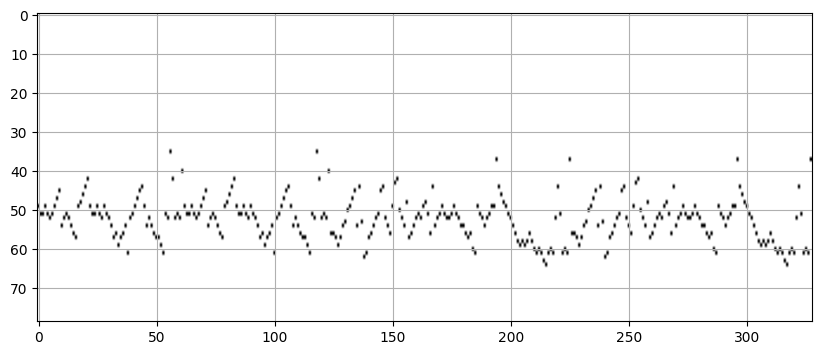

In [8]:
plt.figure(figsize=(10, 4))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

We want to train a language model, i.e. a model thats predict a note given past notes: $p(x^{<\tau>} | x^{<1>}, x^{<2>}, ... x^{<\tau-1>})$.

A simple way to do this is to create (for each MIDI sequence and for each possible starting note `t` within this MIDI sequence) two sequences:
- an input sequence $\{x\}$:
  - which contains a sub-sequence of length `param.model_T_x`;  this sub-sequence range from `t` to `t+param.model_T_x-1`
- an output sequence $\{y\}$ :
  - which contains the same sub-sequence but delayed by one time step: ranging from `t+1` to `t+param.model_T_x`

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_03.png">



In [9]:
def F_convert_list_2_data(X_list, model_T_x, sequence_step=1):
    """
    convert X_list to input X_train and output Y_train training data

    Parameters
    ----------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time
    model_T_x:
        the length of the input and output sequences
    sequence_step:
        the advancement step between successive sequences

    Returns
    -------
    X_train:
        the set of all m input sequences; np.array of shape (m, model_T_x, n_x)
    Y_train:
        the set of all m output sequences; np.array of shape (m, model_T_x, n_x)

            note:   m is the total number of training items,
                    it is be larger than the number of MIDI files since we use several starting time t in each MIDI file
    """

    if student:
        # --- START CODE HERE (02)
        X_train_list = []
        Y_train_list = []
        for X_ohe in X_list:
            for t in range(0, X_ohe.shape[0] - model_T_x, sequence_step):
                X_train_list.append(X_ohe[t:t + model_T_x])
                Y_train_list.append(X_ohe[t + 1:t + model_T_x + 1])
        # --- END CODE HERE

    X_train = np.asarray(X_train_list)
    Y_train = np.asarray(Y_train_list)

    return X_train, Y_train

X_train.shape: (20901, 100, 79)
Y_train.shape: (20901, 100, 79)


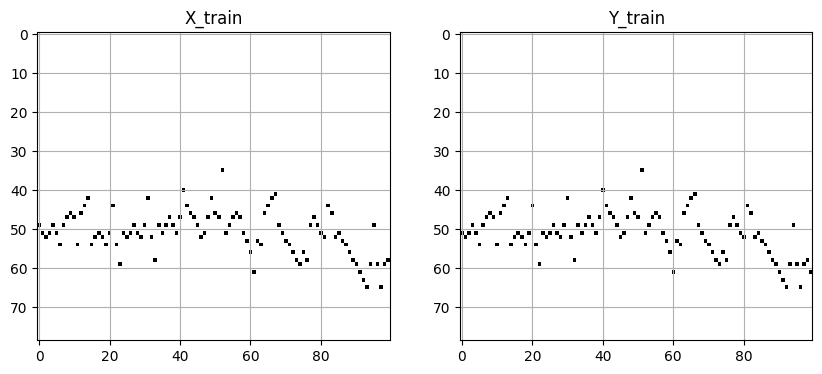

In [10]:
X_train, Y_train = F_convert_list_2_data(X_list, param.model_T_x)
# --- X_train is of shape (m, model_T_x, n_x)
print("X_train.shape:", X_train.shape)
# --- Y_train is of shape (m, model_T_x, n_x)
print("Y_train.shape:", Y_train.shape)


plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.imshow(X_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('X_train')
plt.subplot(1,2,2); plt.imshow(Y_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('Y_train')
plt.set_cmap('gray_r')

# Training the language model

## Creating the model
To learn the language model we will train an RNN with input `X_train` and output `Y_train`.  
For each example, we give to the network a sequence of notes from `t` to `t+param.model_T_x-1`  and ask the network to predict the following note of each sequence `t+1` to `t+param.model_T_x`.
We already created those in `X_train` and `Y_train`.

The network architecture is the following:
- (1a) a layer of `LSTM` with `param.model_n_a` units
- (1b) a layer of DropOut with rate `param.dropout_rate` (which is the probability to "drop-out" one neuron)

- (2a) a layer of `LSTM` with `param.model_n_a` units
- (2b) a layer of DropOut with rate `param.dropout_rate` (which is the probability to "drop-out" one neuron)

- (3) a layer of `LSTM` with `param.model_n_a` units

- (4a) a `Linear` layer projecting to `model_n_a` neurons with a `tanh` activation
- (4b) a layer of DropOut with rate `param.dropout_rate` (which is the probability to "drop-out" one neuron)

- (5) a `Linear` layer projecting to `n_x` neurons

Note that the last `softmax` activation (which predict the probability of each of the $n_x$ notes as output) is not included in the model but will be included directly in the Loss.

Note that the `.forward` method
- also takes as **input** the previous RNN values $s^{(t-1)}$. The previous RNN value sums up the times $x^{(1)} ... x^{(t-1)}$.
In the case of LSTM, $s^{(t-1)}$ is actually a tuple which represent the LSTM hidden state value $h^{(t-1)}$ and LSTM cell (memory) value $c^{(t-1)}$.
Also when several layers of LSTM exist, each layer will have a specific $s^{(t-1)}$ (such as $s^{(t-1),[1]}$, $s^{(t-1),[2]}$ and $s^{(t-1),[3]}$ for three layers).
- also **outputs** the new value of those $s^{(t),[1]}$, $s^{(t),[2]}$ and $s^{(t),[3]}$.

$h$ and $c$ are merged into tuples named `hidden` and since we have three LSTM cell we will have the corresponding `hidden1`, `hidden2` and `hidden3`.   

In [11]:
# --- Create the model

if student:
    # --- START CODE HERE (03)
    class BachModel(nn.Module):

        def __init__(self, param):
            """
            """
            super(BachModel, self).__init__()
            self.lstm1 = nn.LSTM(param.n_x, param.model_n_a, batch_first=True)
            self.dropout1 = nn.Dropout(param.dropout_rate)
            self.lstm2 = nn.LSTM(param.model_n_a, param.model_n_a, batch_first=True)
            self.dropout2 = nn.Dropout(param.dropout_rate)
            self.lstm3 = nn.LSTM(param.model_n_a, param.model_n_a, batch_first=True)
            self.linear1 = nn.Linear(param.model_n_a, param.model_n_a)
            self.dropout3 = nn.Dropout(param.dropout_rate)
            self.linear2 = nn.Linear(param.model_n_a, param.n_x)

        def forward(self, x, hidden1, hidden2, hidden3):
            """
            Parameters
            ----------
                x (batch_size, T_x, n_x)
                    a batch of input sequences
                hidden1
                    a tuple with hidden state h and cell c, each of size (1, batch_size, n_a), to be used as start for lstm of layer1
                hidden2
                    same for layer 2
                hidden3
                    same for layer 3

            Returns
            -------
                logits (batch_size, T_x, n_x)
                    predicted logits (before softmax)
                hidden1
                    new value after processing sequence T_x
                hidden2
                    new value after processing sequence T_x
                hidden2
                    new value after processing sequence T_x
            """
            # --- layer 1
            x, hidden1 = self.lstm1(x, hidden1)
            x = self.dropout1(x)
            # --- layer 2
            x, hidden2 = self.lstm2(x, hidden2)
            x = self.dropout2(x)
            # --- layer 3
            x, hidden3 = self.lstm3(x, hidden3)
            x = self.linear1(x)
            x = F.tanh(x)
            x = self.dropout3(x)
            logits = self.linear2(x)
            
            return logits, hidden1, hidden2, hidden3

        def init_hidden(self, batch_size, model_n_a):
            """
            """
            # Initialize hidden state and cell state with zeros
            hidden1 = (torch.zeros(1, batch_size, model_n_a).float().to(device),
                       torch.zeros(1, batch_size, model_n_a).float().to(device))
            hidden2 = (torch.zeros(1, batch_size, model_n_a).float().to(device),
                       torch.zeros(1, batch_size, model_n_a).float().to(device))
            hidden3 = (torch.zeros(1, batch_size, model_n_a).float().to(device),
                       torch.zeros(1, batch_size, model_n_a).float().to(device))
            return hidden1, hidden2, hidden3

    # --- END CODE HERE


# --- fix seed
import torch
torch.manual_seed(0)

# --- check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model and send it to the GPU if available
model = BachModel(param).to(device)
hidden1, hidden2, hidden3 = model.init_hidden(param.batch_size, param.model_n_a)
print(model)



Using device: cuda
BachModel(
  (lstm1): LSTM(79, 32, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(32, 32, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (lstm3): LSTM(32, 32, batch_first=True)
  (linear1): Linear(in_features=32, out_features=32, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=32, out_features=79, bias=True)
)


/tmp/ipykernel_1387319/3825624930.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.subplot(212), plt.imshow(F.softmax(output[0,:,:]).detach().cpu().T.numpy(), aspect='auto', origin='lower', interpolation='none');


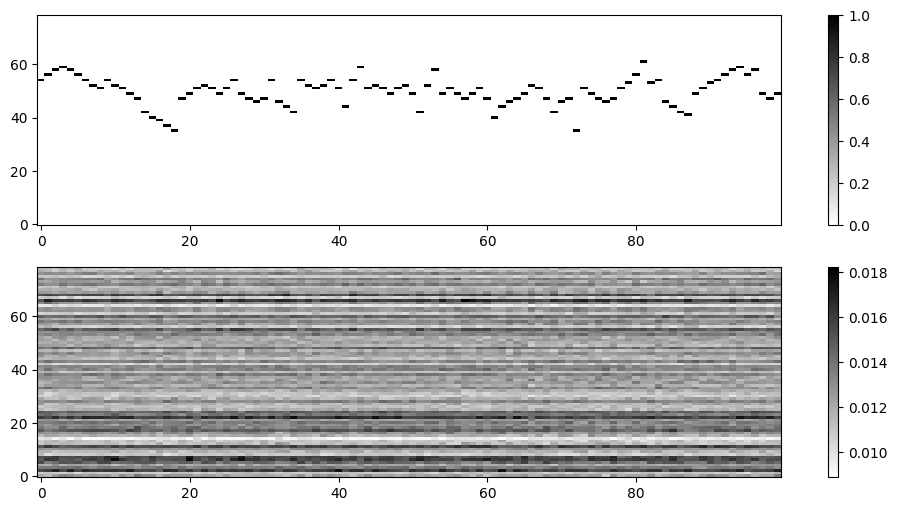

In [12]:
def plot_test(X_train):
    """
    display the obtained probability estimation for a given sequence
    """
    # ----------------------------------------------
    input = torch.tensor(X_train[:1,:,:]).float()
    hidden1, hidden2, hidden3 = model.init_hidden(input.size(0), param.model_n_a)
    output, _, _, _ = model( input.to(device), hidden1, hidden2, hidden3 )
    #print(f'input: {input.size()} hidden1: {hidden1[0].size()} output: {output.size()}')

    plt.figure(figsize=(12,6))
    plt.subplot(211), plt.imshow(input[0,:,:].T.numpy(), aspect='auto', origin='lower', interpolation='none');
    plt.colorbar()
    plt.subplot(212), plt.imshow(F.softmax(output[0,:,:]).detach().cpu().T.numpy(), aspect='auto', origin='lower', interpolation='none');
    plt.colorbar()
    plt.show()

plot_test(X_train)

In [17]:
def train_one_epoch(model, data_loader, criterion, optimizer):
    """
    """

    model.train()
    total_loss = 0
    for X, y in data_loader:
        optimizer.zero_grad()
        # --- X (m, T_x, n_x)
        m = X.size(0)
        hidden1, hidden2, hidden3 = model.init_hidden(m, param.model_n_a)
        hat_y, _, _, _ = model( X, hidden1, hidden2, hidden3 )
        hat_y = hat_y.view(m * param.model_T_x, param.n_x)
        y_bol = torch.argmax(y, dim=2)
        y_bol = y_bol.view(m * param.model_T_x)

        loss = criterion(hat_y, y_bol)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

In [18]:
def train(model, X_train, Y_train, epochs=param.n_epoch, batch_size=param.batch_size):

    """
    train the model

    Parameters
    ----------
    model:
        ...


    Returns
    -------
    """

    # --- Move the model to the device (GPU or CPU)
    model = model.to(device)

    # ---  Convert numpy.arrays to torch.tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

    # ---  Create Datasets for train data
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

    # --- Create Dataloader for train data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # ---  Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=0.01)

    # ---  Training loop
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        print(f"Epoch {epoch + 1}, Loss: {train_loss }")
        if epoch%100==0:
            plot_test(X_train)

Epoch 1, Loss: 3.073820655863584


/tmp/ipykernel_1313073/3825624930.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.subplot(212), plt.imshow(F.softmax(output[0,:,:]).detach().cpu().T.numpy(), aspect='auto', origin='lower', interpolation='none');


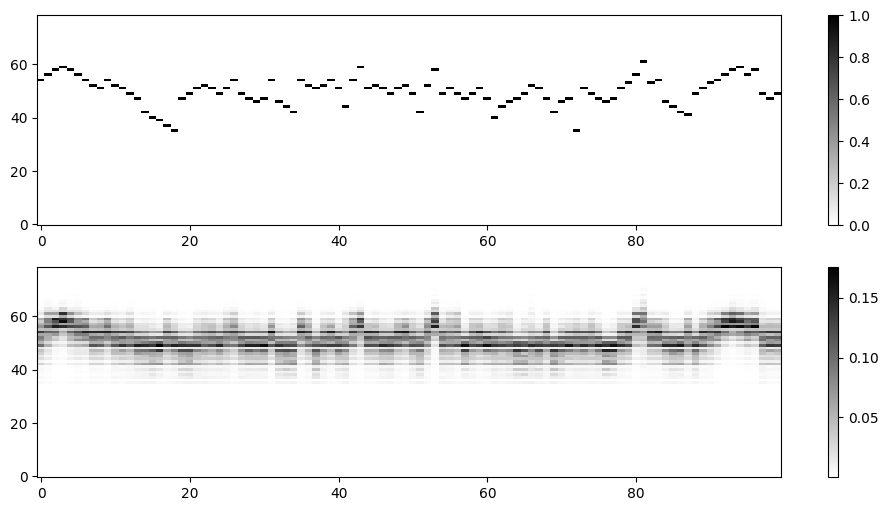

Epoch 2, Loss: 2.552877790701863
Epoch 3, Loss: 2.2750240203437455
Epoch 4, Loss: 2.114893348574274
Epoch 5, Loss: 2.020601490951095
Epoch 6, Loss: 1.9665557408551557
Epoch 7, Loss: 1.9235057812582828
Epoch 8, Loss: 1.8929462440152416
Epoch 9, Loss: 1.8660178374077567
Epoch 10, Loss: 1.8463720185311927
Epoch 11, Loss: 1.8318452091392028
Epoch 12, Loss: 1.8181048602503738
Epoch 13, Loss: 1.8066855308112748
Epoch 14, Loss: 1.793944230502534
Epoch 15, Loss: 1.785319513501742
Epoch 16, Loss: 1.7764772089249496
Epoch 17, Loss: 1.7701125236097097
Epoch 18, Loss: 1.7618231463505223
Epoch 19, Loss: 1.7573529481887817
Epoch 20, Loss: 1.750940523380898
Epoch 21, Loss: 1.7448659358768288
Epoch 22, Loss: 1.740895838183365
Epoch 23, Loss: 1.73568417573923
Epoch 24, Loss: 1.7350885529036915
Epoch 25, Loss: 1.7287884236111188
Epoch 26, Loss: 1.7233469252921754
Epoch 27, Loss: 1.7188620104337686
Epoch 28, Loss: 1.7177544617142517
Epoch 29, Loss: 1.71228681791813
Epoch 30, Loss: 1.712379151892589
Epoch

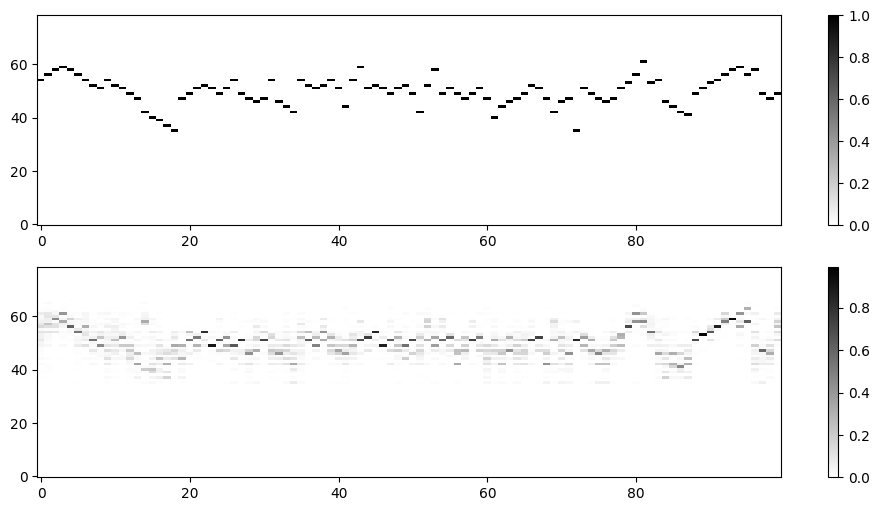

Epoch 102, Loss: 1.6262560269883648
Epoch 103, Loss: 1.6283055008004566
Epoch 104, Loss: 1.6272557197360817
Epoch 105, Loss: 1.6265248705487731
Epoch 106, Loss: 1.6250026893178258
Epoch 107, Loss: 1.624654238012588
Epoch 108, Loss: 1.623866652129987
Epoch 109, Loss: 1.6220414645810375
Epoch 110, Loss: 1.6238172520920406
Epoch 111, Loss: 1.6236208145042443
Epoch 112, Loss: 1.6198712459762528
Epoch 113, Loss: 1.6193024762179873
Epoch 114, Loss: 1.6217505621983006
Epoch 115, Loss: 1.6192237186140241
Epoch 116, Loss: 1.6242944767715735
Epoch 117, Loss: 1.6172727904188524
Epoch 118, Loss: 1.6167128381379154
Epoch 119, Loss: 1.6162066962740838
Epoch 120, Loss: 1.6189162844182519
Epoch 121, Loss: 1.6192991237757037
Epoch 122, Loss: 1.6144193676998126
Epoch 123, Loss: 1.6142824472637352
Epoch 124, Loss: 1.6221800852988473
Epoch 125, Loss: 1.610487998443277
Epoch 126, Loss: 1.6165285894265597
Epoch 127, Loss: 1.6277812030337273
Epoch 128, Loss: 1.6206322099090715
Epoch 129, Loss: 1.624962859926

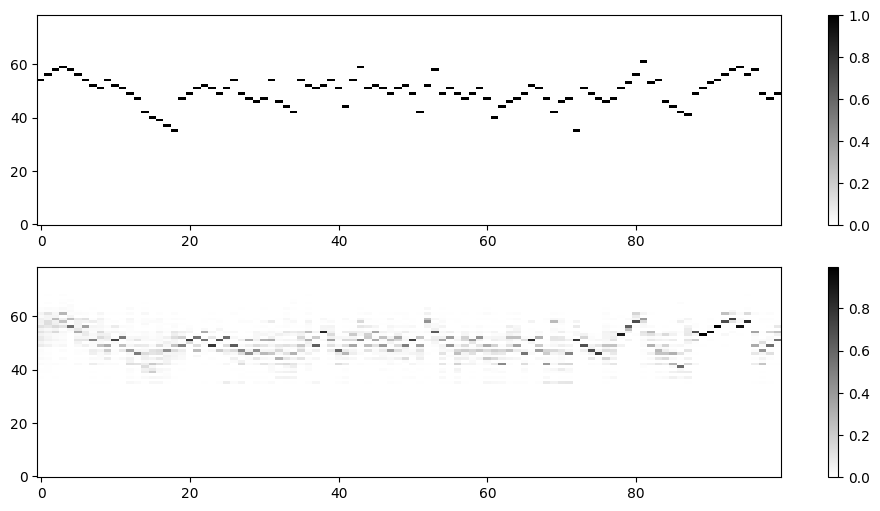

Epoch 202, Loss: 1.590536462057621
Epoch 203, Loss: 1.5882309011727662
Epoch 204, Loss: 1.5925954405320895
Epoch 205, Loss: 1.6146080198637935
Epoch 206, Loss: 1.5896079328811132
Epoch 207, Loss: 1.5886362043724878
Epoch 208, Loss: 1.5878081507639055
Epoch 209, Loss: 1.5875461083304263
Epoch 210, Loss: 1.5880354752234362
Epoch 211, Loss: 1.5888171658967978
Epoch 212, Loss: 1.5892516265221692
Epoch 213, Loss: 1.590673741579785
Epoch 214, Loss: 1.5902619923291221
Epoch 215, Loss: 1.5874950247802502
Epoch 216, Loss: 1.5916555584023853
Epoch 217, Loss: 1.585592238181228
Epoch 218, Loss: 1.5888472044504383
Epoch 219, Loss: 1.6211069180695654
Epoch 220, Loss: 1.5845031559649594
Epoch 221, Loss: 1.5960504687889636
Epoch 222, Loss: 1.5887459031667914
Epoch 223, Loss: 1.591373075039015
Epoch 224, Loss: 1.585158928818659
Epoch 225, Loss: 1.5874119585078061
Epoch 226, Loss: 1.586605226592551
Epoch 227, Loss: 1.585805795243756
Epoch 228, Loss: 1.5894583744375712
Epoch 229, Loss: 1.5842228205561273

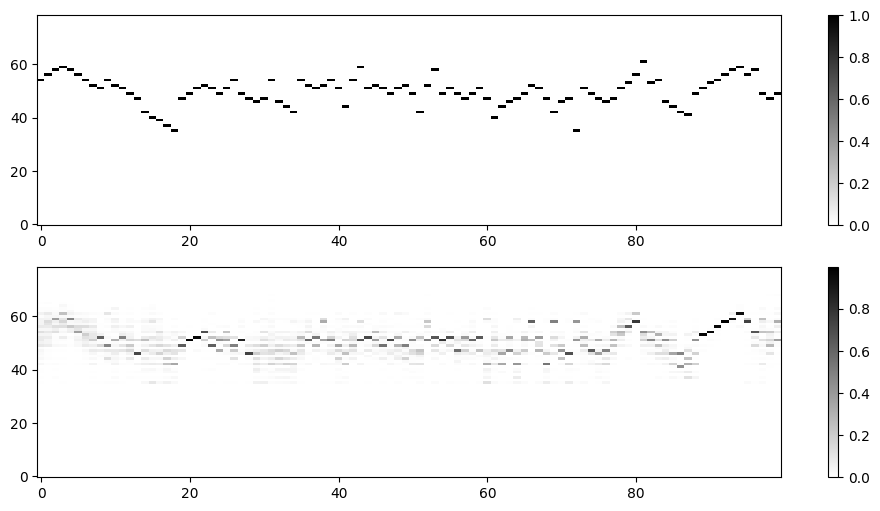

Epoch 302, Loss: 1.5727547855552184
Epoch 303, Loss: 1.5712626352222687
Epoch 304, Loss: 1.5763254227623662
Epoch 305, Loss: 1.5740540056782761
Epoch 306, Loss: 1.5776166533111433
Epoch 307, Loss: 1.5730492507281288
Epoch 308, Loss: 1.5783944016931983
Epoch 309, Loss: 1.5737615856555625
Epoch 310, Loss: 1.574279130781098
Epoch 311, Loss: 1.569949156282874
Epoch 312, Loss: 1.5824086928586347
Epoch 313, Loss: 1.5783938709019885
Epoch 314, Loss: 1.5731829966244713
Epoch 315, Loss: 1.5704586206955282
Epoch 316, Loss: 1.5720077315601735
Epoch 317, Loss: 1.5733907007660706
Epoch 318, Loss: 1.5880645320320712
Epoch 319, Loss: 1.5717036097057004
Epoch 320, Loss: 1.5673374028745413
Epoch 321, Loss: 1.5723097408218851
Epoch 322, Loss: 1.5807186762491863
Epoch 323, Loss: 1.5749592223298658
Epoch 324, Loss: 1.569055361120708
Epoch 325, Loss: 1.5749304043043644
Epoch 326, Loss: 1.5766016489139756
Epoch 327, Loss: 1.572239829495048
Epoch 328, Loss: 1.5877123010267906
Epoch 329, Loss: 1.5670213254584

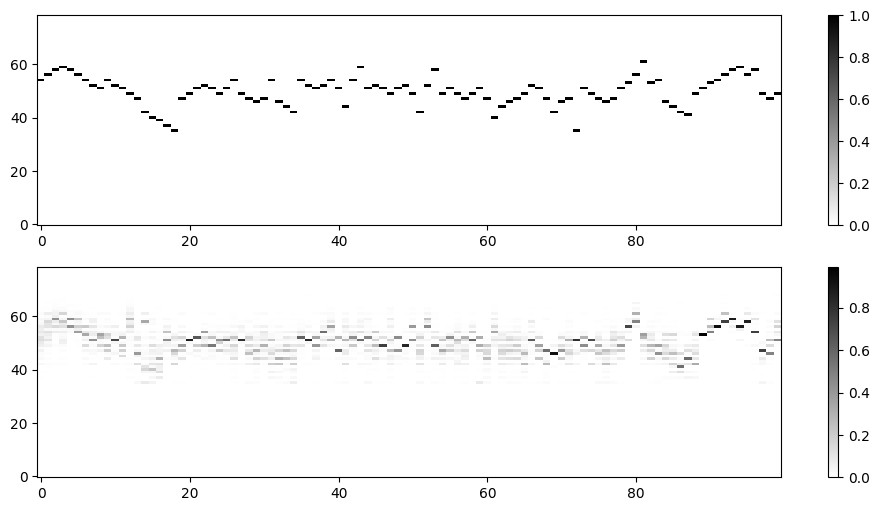

Epoch 402, Loss: 1.5618713314015567
Epoch 403, Loss: 1.5626158251310343
Epoch 404, Loss: 1.5624359995582418
Epoch 405, Loss: 1.5689464523157943
Epoch 406, Loss: 1.5643822570824113
Epoch 407, Loss: 1.5610299905141194
Epoch 408, Loss: 1.567454962919976
Epoch 409, Loss: 1.560313866772783
Epoch 410, Loss: 1.5594702802302276
Epoch 411, Loss: 1.5848789462984885
Epoch 412, Loss: 1.5580461586651817
Epoch 413, Loss: 1.5638616613656373
Epoch 414, Loss: 1.5704493449733163
Epoch 415, Loss: 1.5575206804712978
Epoch 416, Loss: 1.5617594810071707
Epoch 417, Loss: 1.5636120691941053
Epoch 418, Loss: 1.560003926265495
Epoch 419, Loss: 1.5630549429388951
Epoch 420, Loss: 1.5681650259443745
Epoch 421, Loss: 1.5607805795261254
Epoch 422, Loss: 1.5617375311866084
Epoch 423, Loss: 1.563099654078119
Epoch 424, Loss: 1.5608548297794587
Epoch 425, Loss: 1.5616412363285683
Epoch 426, Loss: 1.591563888646047
Epoch 427, Loss: 1.5599461050208556
Epoch 428, Loss: 1.559485901386366
Epoch 429, Loss: 1.558958136342716

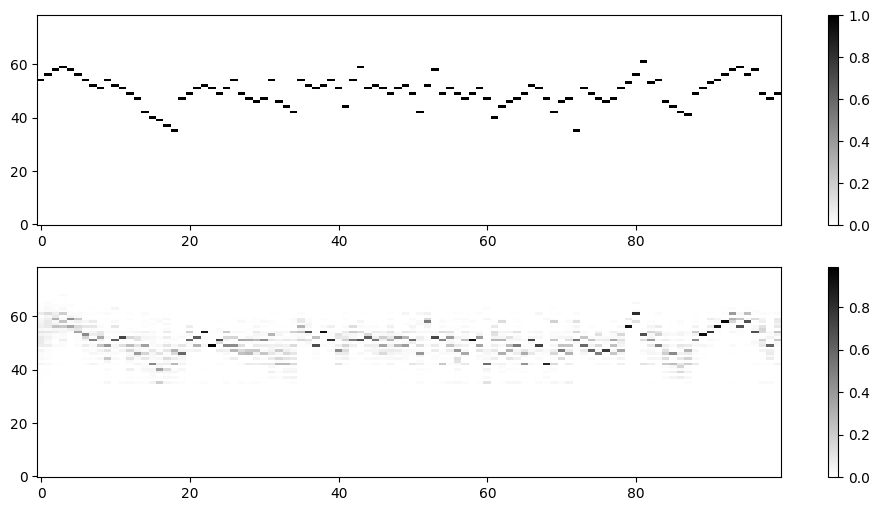

Epoch 502, Loss: 1.557886664291405
Epoch 503, Loss: 1.5597746638347614
Epoch 504, Loss: 1.5555715006790394
Epoch 505, Loss: 1.5526930122929612
Epoch 506, Loss: 1.5525112903081677
Epoch 507, Loss: 1.558922024312734
Epoch 508, Loss: 1.553802404199536
Epoch 509, Loss: 1.5597295834019278
Epoch 510, Loss: 1.5585792261526126
Epoch 511, Loss: 1.556876204064862
Epoch 512, Loss: 1.5525893902559893
Epoch 513, Loss: 1.5551839866404868
Epoch 514, Loss: 1.55298097673177
Epoch 515, Loss: 1.549569765362171
Epoch 516, Loss: 1.5540381629897184
Epoch 517, Loss: 1.55440436991712
Epoch 518, Loss: 1.554594981196459
Epoch 519, Loss: 1.5693370515782534
Epoch 520, Loss: 1.5532636934099577
Epoch 521, Loss: 1.558915801733641
Epoch 522, Loss: 1.5549723715592598
Epoch 523, Loss: 1.5544158234873313
Epoch 524, Loss: 1.5627288585044556
Epoch 525, Loss: 1.5530200627965665
Epoch 526, Loss: 1.5527714377878639
Epoch 527, Loss: 1.558742308835371
Epoch 528, Loss: 1.5520204925391288
Epoch 529, Loss: 1.5545295177978842
Epoc

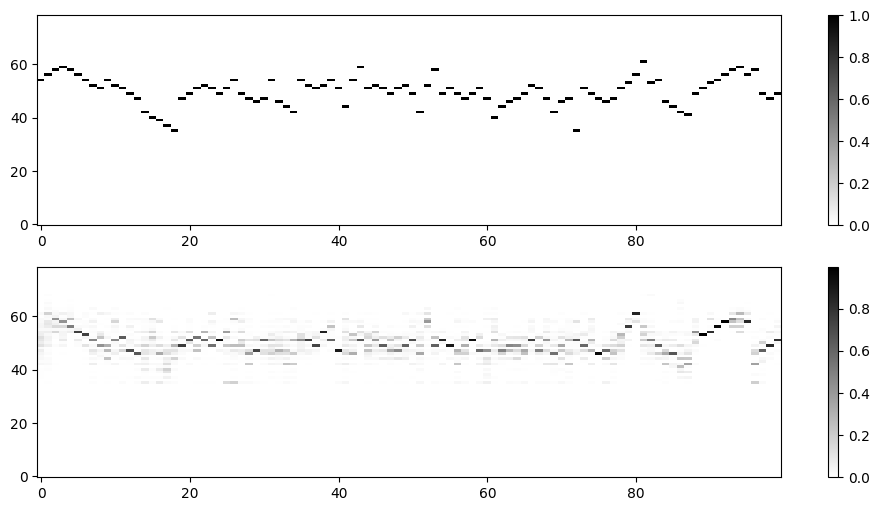

Epoch 602, Loss: 1.5522254716365709
Epoch 603, Loss: 1.556825521159974
Epoch 604, Loss: 1.5530115183704853
Epoch 605, Loss: 1.5568885496996958
Epoch 606, Loss: 1.5462278638046452
Epoch 607, Loss: 1.5556085481556183
Epoch 608, Loss: 1.5580324211616399
Epoch 609, Loss: 1.5463536077318571
Epoch 610, Loss: 1.5548515804681573
Epoch 611, Loss: 1.5493087578986398
Epoch 612, Loss: 1.5463533463463506
Epoch 613, Loss: 1.5539323846134572
Epoch 614, Loss: 1.5553581893261783
Epoch 615, Loss: 1.5540146014741436
Epoch 616, Loss: 1.5492991420471705
Epoch 617, Loss: 1.5501932266655318
Epoch 618, Loss: 1.5487316821328727
Epoch 619, Loss: 1.545708123332499
Epoch 620, Loss: 1.5532905486745572
Epoch 621, Loss: 1.5463146674888215
Epoch 622, Loss: 1.5584457897629578
Epoch 623, Loss: 1.5658807484746344
Epoch 624, Loss: 1.5796098063845154
Epoch 625, Loss: 1.5460904213266635
Epoch 626, Loss: 1.544503897337374
Epoch 627, Loss: 1.5517418504854954
Epoch 628, Loss: 1.5434626570535361
Epoch 629, Loss: 1.551037615227

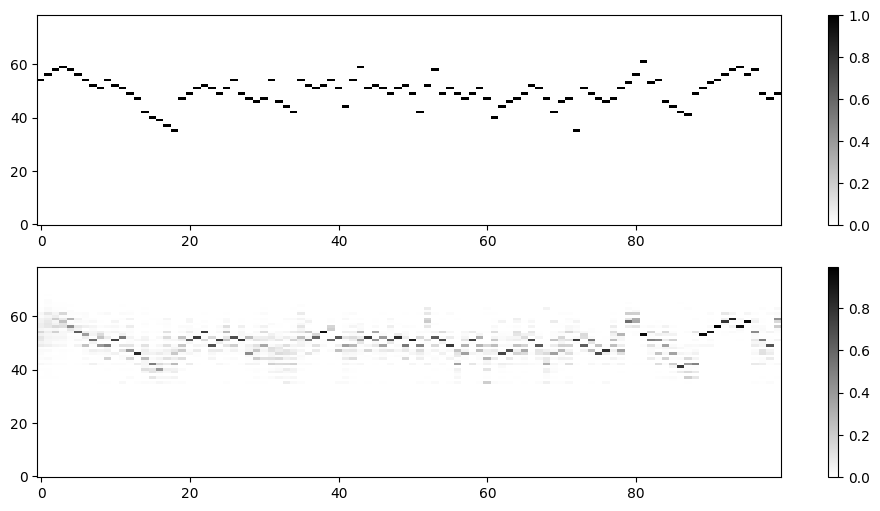

Epoch 702, Loss: 1.5454703321515237
Epoch 703, Loss: 1.541724307456877
Epoch 704, Loss: 1.5435678525073084
Epoch 705, Loss: 1.543574997409039
Epoch 706, Loss: 1.5797571723978818
Epoch 707, Loss: 1.5439055454475799
Epoch 708, Loss: 1.55362607871356
Epoch 709, Loss: 1.5471933015625046
Epoch 710, Loss: 1.549508087861064
Epoch 711, Loss: 1.5422385799775429
Epoch 712, Loss: 1.553498066528857
Epoch 713, Loss: 1.5406872701207432
Epoch 714, Loss: 1.5712874267443968
Epoch 715, Loss: 1.5466429644039283
Epoch 716, Loss: 1.5493639652882147
Epoch 717, Loss: 1.5415446145818867
Epoch 718, Loss: 1.5475094267352276
Epoch 719, Loss: 1.5503569305489917
Epoch 720, Loss: 1.5426311558539714
Epoch 721, Loss: 1.5428038744386912
Epoch 722, Loss: 1.5416969414515598
Epoch 723, Loss: 1.5435415057961
Epoch 724, Loss: 1.5544956386636157
Epoch 725, Loss: 1.547123616259397
Epoch 726, Loss: 1.548380777011953
Epoch 727, Loss: 1.5399515654333504
Epoch 728, Loss: 1.5541333062204017
Epoch 729, Loss: 1.554028336790359
Epoc

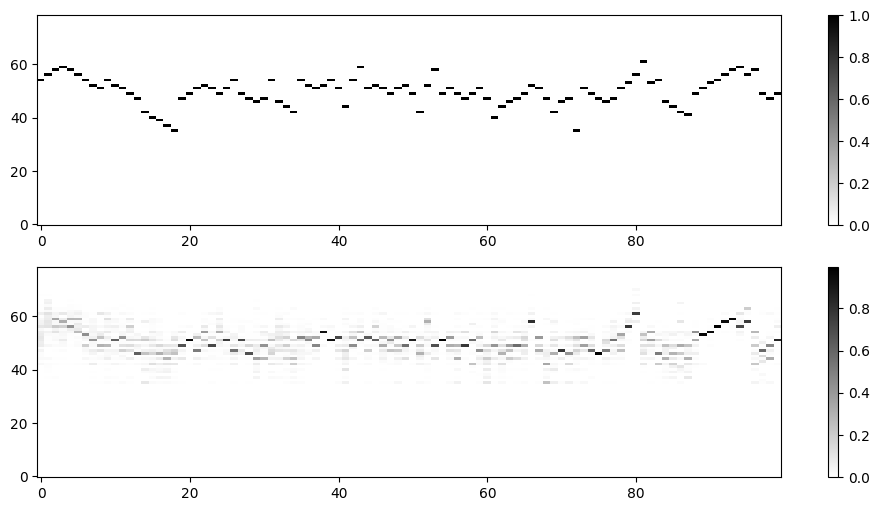

Epoch 802, Loss: 1.5468066715683777
Epoch 803, Loss: 1.5389802802228782
Epoch 804, Loss: 1.556441967640448
Epoch 805, Loss: 1.54295005893124
Epoch 806, Loss: 1.5419716182469592
Epoch 807, Loss: 1.5331044598092363
Epoch 808, Loss: 1.5432443290675453
Epoch 809, Loss: 1.5446699201513867
Epoch 810, Loss: 1.542745166233191
Epoch 811, Loss: 1.5404723598322738
Epoch 812, Loss: 1.553731337599798
Epoch 813, Loss: 1.5706727205795614
Epoch 814, Loss: 1.5419772433213867
Epoch 815, Loss: 1.5351071984760623
Epoch 816, Loss: 1.543676490083747
Epoch 817, Loss: 1.5421364912563873
Epoch 818, Loss: 1.5412196365700586
Epoch 819, Loss: 1.5436845434550481
Epoch 820, Loss: 1.5463857931463725
Epoch 821, Loss: 1.5641357570613197
Epoch 822, Loss: 1.5615797819347557
Epoch 823, Loss: 1.5717323992959586
Epoch 824, Loss: 1.5342280861070032
Epoch 825, Loss: 1.542496296973039
Epoch 826, Loss: 1.5372265675745973
Epoch 827, Loss: 1.5429678378848855
Epoch 828, Loss: 1.5394505878471818
Epoch 829, Loss: 1.5486564858608654

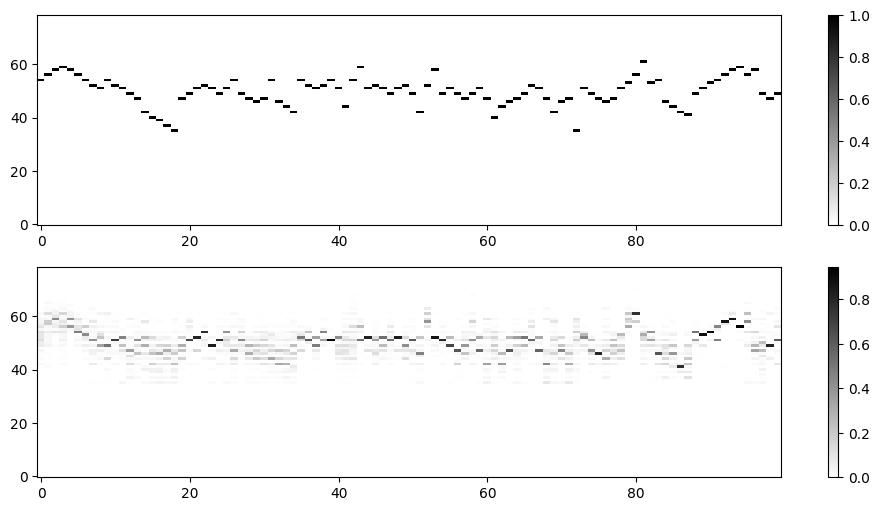

Epoch 902, Loss: 1.5325893921954188
Epoch 903, Loss: 1.5397893992403595
Epoch 904, Loss: 1.5411480045464425
Epoch 905, Loss: 1.537579790896961
Epoch 906, Loss: 1.552294496731656
Epoch 907, Loss: 1.537766382234906
Epoch 908, Loss: 1.5472621265172228
Epoch 909, Loss: 1.5496644503479704
Epoch 910, Loss: 1.5402519032131277
Epoch 911, Loss: 1.532249690195836
Epoch 912, Loss: 1.5524800399756942
Epoch 913, Loss: 1.5450749244164983
Epoch 914, Loss: 1.5346092707520231
Epoch 915, Loss: 1.535503546032337
Epoch 916, Loss: 1.5333372442000504
Epoch 917, Loss: 1.5969178027698387
Epoch 918, Loss: 1.5458807912441568
Epoch 919, Loss: 1.553523399778827
Epoch 920, Loss: 1.5372243926430331
Epoch 921, Loss: 1.5918247783585062
Epoch 922, Loss: 1.5791493767262963
Epoch 923, Loss: 1.5360884024827124
Epoch 924, Loss: 1.5362923079674398
Epoch 925, Loss: 1.5423854286882126
Epoch 926, Loss: 1.5317511029928832
Epoch 927, Loss: 1.5305466527968008
Epoch 928, Loss: 1.5342810150315638
Epoch 929, Loss: 1.534799076730687

In [19]:
train(model, X_train, Y_train)

In [20]:
# Specify the file path to save the model
model_path = './model.pth'

# Save the model
torch.save(model.state_dict(), model_path)

print("Model saved successfully.")

Model saved successfully.


In [18]:
# Specify the file path to load the model
model_path = './model.pth'

# Instantiate the model
model = BachModel(param)

# Load the saved model state
model.load_state_dict(torch.load(model_path))

model.to(device)

print("Model loaded successfully.")

Model loaded successfully.


# Generating a new sequence by sampling the language model

<img src="https://docs.google.com/uc?export=download&id=129zZNNKNq1oXG21kLKDDUvGY_po6eS6Q" width=700>

To generate a new sequence using the trained language model, we will use an **auto-regressive** method: we generate time-step $t$ based on the previously generated time-steps $0$ to $t-1$.

For the first step
- $\hat{y}^{(1)} = p(x^{(2)} | \color{red}{x^{(1)}} ; \color{blue}{s^{(0)}=[-]})\\x^{(2)} \sim \hat{y}^{(1)}$

For the second step
- $\hat{y}^{(2)} = p(x^{(3)} | \color{red}{x^{(2)}} ; \color{blue}{s^{(1)}=[x^{(1)}]})\\x^{(3)} \sim \hat{y}^{(2)}$

The third step
- $\hat{y}^{(3)} = p(x^{(4)} |\color{red}{ x^{(3)}} ; \color{blue}{s^{(2)}=[x^{(1)} x^{(2)}]})\\x^{(4)} \sim \hat{y}^{(3)}$

For the $t$ step:
- $\hat{y}^{(t)} = p(x^{(t+1)} | \color{red}{{x^{(t)}}} ; \color{blue}{s^{(t-1)}=[x^{(1)} ... x^{(t-1)}]})\\x^{(t+1)} \sim \hat{y}^{(t)}$

In the above "$\sim$" denotes "sampled from the distribution"

At time step $t$, the model gets
- as input (red part): the previous generated time step $x^{(t)} \sim \hat{y}^{(t-1)}$
- as previous RNN value (blue part) $s^{(t-1)}$. The previous RNN value sums up the times $x^{(1)} ... x^{(t-1)}$.
In the case of LSTM, $s^{(t-1)}$ is actually a tuple which represent the LSTM hidden state value $h^{(t-1)}$ and LSTM cell (memory) value $c^{(t-1)}$.
Also when several layers of LSTM exist, each layer will have a specific $s^{(t-1)}$ (such as $s^{(t-1),[1]}$, $s^{(t-1),[2]}$ and $s^{(t-1),[3]}$ for three layers).


### Initialisation (`t=1`)

For the start, we set $x^{(1)}$ to a randomly choosen note among the `param.n_x` possible notes. For this you can
- either sample from an uniform distribution among the notes -> `get_prior_uniform`
- or sample from a prior note distribution (the prior can be obtained by counting the number of occurences of each notes in the training set) -> `get_prior_data_distribution`

To sample from a distribution you can use `np.random.multinomial`.

We then create an input `x` that will be used by our `model`. Our model requires data of shape `(m, T_x, n_x)`. In our case
- `m=1` since we have only one sequence,
- `T_x=1` since we only consider one time at a given time (auto-regressive)
- `n_x` is the number of notes.

We set the input data `x[0,0,:]` to the one-hot-encoding of our random note $x^{(1)}$.

For the start, we do not have previous RNN values, we therefore set $s^{(0)}$ to 0.
This is done using `model.init_hidden`. We denote those `hidden1, hidden2, hidden3`.

We then feed our model with data `x[0,0,:]` and `hidden1, hidden2, hidden3`.

### Loop

At time $t$, our model predict $\hat{y}^{(t)}=p(x^{(t+1)} | \color{red}{{x^{(t)}}} ; \color{blue}{s^{(t-1)}=[x^{(1)} ... x^{(t-1)}]})$.

The inputs of the model are
- the one-hot-encoding of the previously chosen note $x^{(t)} \sim \hat{y}^{(t-1)}$; it is stored in `x[0,0,:]`
- the previous RNN value $s^{(t-1)}$; it is stored in `hidden1, hidden2, hidden3`

The outputs of `model.forward()` are
- the `logits` $\in [-\inf,\inf]$ of shape `(1, 1, n_x)` of each note (remember that the `softmax` is not part of our model; the softmax is included in the Loss, not in the model).
- the new RNN values $s^{(t)}$

To get $\hat{y}^{(t)}$ from the logits at time `t`, we can  
- (a) either convert this logit vector to a probablity using standard softmax -> `get_softmax`
- (b) or convert this logit vector to a probablity using a softmax **with temperature** -> `get_softmax_temperature`.
To apply a temperature $T$ parameter to a discrete probability $\{p_c\}_{c \in \{1,...,K\}}$, you can use
$p'_c = \frac{e^{\log(p_c)/T}}{\sum_{k=1}^K e^{\log(p_k)/T}}$ where $K$ is the number of classes.

To get $x^{(t+1)}$ from the resulting probablity $\hat{y}^{(t)}$ we can then
- (a) either select the largest probability -> `np.argmax`
- (b) or consider the probability as a multinomial distribution and sample from it -> `np.random.multinomial`.

We append the chosen note $x^{(t+1)}$ to the list of chosen notes ->  `note_l.append()`.
We append the used probablity $\hat{y}^{(t)}$ to the list of probablities -> `prediction_l.append()`.

### Stop criteria

We repeat the process until we generate the required amount of notes `param.model_T_generate`.





In [14]:
# --- np: numpy
# --- to: pytorch

def get_prior_uniform(n_x):
    """
    """
    prior_np_v = np.ones(n_x)/n_x
    return prior_np_v

def get_prior_data_distribution(X_train_np, n_x):
    """
    """
    sum_np_v = np.zeros(n_x)
    for X_ohe_np in X_train_np:
        sum_np_v += np.sum(X_ohe_np, axis=0)
    prior_np_v = sum_np_v/np.sum(sum_np_v)
    return prior_np_v

def get_softmax(hat_logit_to):
    """
    """
    proba_np_v = np.exp(hat_logit_to)/np.sum(np.exp(hat_logit_to))
    return proba_np_v
    

def get_softmax_temperature(hat_logit_to, temperature):
    """
    compute a softmax with temperature

    Parameters
    ----------
    logits_v: n_x
        input un-normalized logits \in [-inf, inf]
    temperature: scalar float
        temperature parameters to apply to proba_v,
        >1 leads to more flatten probability,
        <1 leads to more peaky probability

    Returns
    -------
    proba_v: np.array(n_x)
        probability scaled by temperature
    """
    if student:
        # --- START CODE HERE (04)
        proba_v = np.exp(hat_logit_to/temperature)
        proba_v = proba_v/np.sum(proba_v)
        proba_np_v = proba_v
        # --- END CODE HERE

    return proba_np_v

def choose_max(proba_np_v):
    """
    """
    index_pred = np.argmax(proba_np_v)
    return index_pred

def choose_max_multinormial(proba_np_v):
    """
    """
    index_pred = np.argmax(np.random.multinomial(1, proba_np_v))
    return index_pred

In [19]:
def F_sample_new_sequence(model):
    """
    sample the trained language model to generate new data

    Parameters
    ----------
    model:
        trained language model

    Returns
    -------
    note_l: list of int
        list of generated notes (list of their index)
    prediction_l: list of np.array(n_x)
        list of prediction probabilies over time t (each entry of the list is one of the y[0,t,:])
    """

    np.random.seed(0);
    note_l = []
    prediction_l = []

    if student:
        # --- START CODE HERE (05)
        hidden1, hidden2, hidden3 = model.init_hidden(1, param.model_n_a)
        X = np.zeros((1, 1, param.n_x))
        # draw a random note to init
        X[0, 0, np.random.randint(param.n_x)] = 1
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        
        for t in range(param.model_T_generate):
            hat_y, hidden1, hidden2, hidden3 = model(X_tensor, hidden1, hidden2, hidden3)
            hat_y = hat_y[:, -1, :]  # We only care about the last output in the sequence
            hat_y = hat_y.view(param.n_x)
            hat_y = F.softmax(hat_y, dim=0).detach().cpu().numpy()
            prediction_l.append(hat_y)
            index_pred = choose_max(hat_y)
            note_l.append(index_pred)
            
            # Update the input sequence X_tensor
            new_note = np.zeros((1, 1, param.n_x))
            new_note[0, 0, index_pred] = 1
            X = np.concatenate((X, new_note), axis=1)  # add the new note
            X = X[:, -param.model_T_x:, :]  # Truncate the sequence if necessary
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        # --- END CODE HERE

    return note_l, prediction_l

### Display the generated sequence

[49, 51, 51, 49, 46, 51, 52, 49, 51, 52, 49, 51, 53, 54, 49, 51, 53, 54, 56, 59, 59, 61, 53, 56, 54, 59, 58, 56, 58, 59, 61, 59, 58, 56, 54, 59, 58, 56, 56, 54, 54, 56, 53, 58, 54, 56, 58, 54, 51, 49, 51, 49, 47, 48, 51, 53, 54, 53, 54, 56, 54, 59, 61, 58, 56, 54, 52, 51, 52, 54, 51, 47, 46, 44, 42, 58, 59, 58, 55, 54, 49, 51, 49, 54, 49, 47, 46, 49, 54, 58, 61, 59, 61, 58, 54, 52, 58, 54, 56, 58]


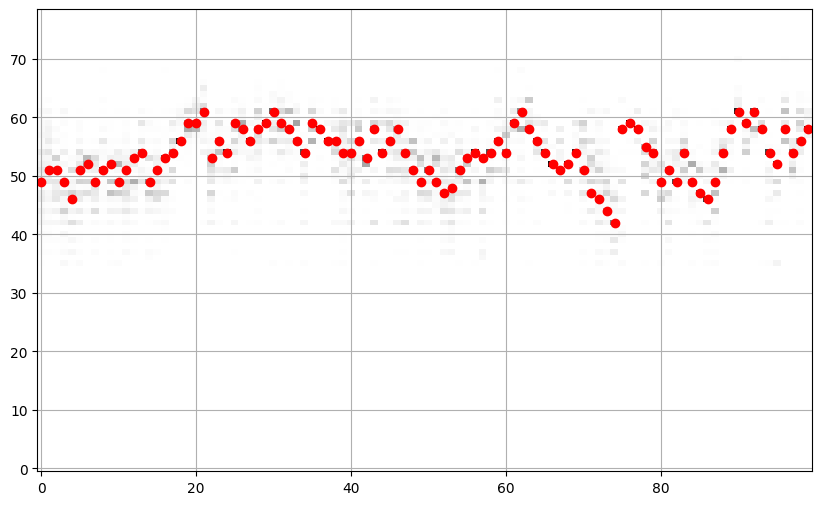

In [20]:
note_l, prediction_l = F_sample_new_sequence(model)

print(note_l)
plt.figure(figsize=(10, 6))
plt.imshow(np.asarray(prediction_l).T, aspect='auto', origin='lower')
plt.plot(note_l, 'ro')
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [34]:
new_midi_data = pretty_midi.PrettyMIDI()
instrument_id = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
instrument = pretty_midi.Instrument(program=instrument_id)
print(instrument)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    instrument.notes.append(myNote)
    time += step
new_midi_data.instruments.append(instrument)
new_midi_data.write('new_midi.mid')

Instrument(program=0, is_drum=False, name="")


In [35]:
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)

# Evaluation

To evaluate the work, you should rate the code for
- 1) MIDI conversion to one-hot-encoding: `F_convert_midi_2_list` (01)
- 2) Data conversion for the training of language model (02) `F_convert_list_2_data`
- 3) Training the language model (03)
- 4) Generating a new sequence from sampling the language model `F_sample_new_sequence` (04)
